In [ ]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import * 

%load_ext autoreload
%autoreload 2

niks_domain = '[XNGDRYS]IK[SDLT]'
ycf_domain = 'Y.C...F'

In [ ]:
def get_genome_id_numbers(genome_ids):
    return np.array([re.search(r'(\d{2,})', genome_id).group(1) for genome_id in genome_ids])

In [ ]:
genome_metadata_df = pd.read_csv('../data/ar53_metadata_r226.tsv', sep='\t')
genome_metadata_df.accession = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in genome_metadata_df.accession]
print('Num. GTDB archaeal genomes:', len(genome_metadata_df))

genome_metadata_df = genome_metadata_df[genome_metadata_df.checkm_completeness > 80].copy()
rep_genome_ids = genome_metadata_df.gtdb_genome_representative.unique()
rep_genome_ids = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in rep_genome_ids]

print('Num. GTDB archaeal genomes with CheckM completeness > 80%:', len(genome_metadata_df))
print('Num. GTDB representatives with CheckM completeness > 80%::', len(rep_genome_ids))

kivenson_genome_ids = pd.read_csv('../data/kivenson_2023_table_2.csv')['Assembly Accession'].tolist() # Get the genomes reported to have Pyl machinery. 

# For some reason, there are genome IDs in SI Table 5 which are not in the SI Table 2 list, so had to add them seperately. 
table_5_metadata_df = pd.read_csv('../data/kivenson_2023_table_5.csv')
table_5_metadata_df['accession'] = ['_'.join(file_name.split('_')[:2]) for file_name in table_5_metadata_df['Filename']]
table_5_metadata_df = table_5_metadata_df.set_index('accession')

kivenson_genome_ids += table_5_metadata_df.index.tolist()
kivenson_genome_ids = list(set(kivenson_genome_ids))
print('Num. genomes from Kivenson et. al. 2023:', len(kivenson_genome_ids))

# rep_genome_id_numbers = get_genome_id_numbers(rep_genome_ids)
# kivenson_genome_id_numbers  = get_genome_id_numbers(kivenson_genome_ids)
# rep_genome_ids = np.array(rep_genome_ids)[~np.isin(rep_genome_id_numbers, kivenson_genome_id_numbers)].tolist()

genome_ids = list(set(kivenson_genome_ids + rep_genome_ids))

downloader = NCBI()
downloader.get_genomes(genome_ids)
extract()

downloaded_genome_ids = [file_name.replace('.fa', '') for file_name in os.listdir('../data/ncbi/proteins/')]
genome_metadata_df = genome_metadata_df[genome_metadata_df.accession.isin(downloaded_genome_ids)]
genome_metadata_df = genome_metadata_df.set_index('accession')

print('Num. total genomes:', len(genome_ids))


In [ ]:
# for path in tqdm(glob.glob('../data/ncbi/genomes/*'), 'Running Prodigal with default code on Archaeal genomes.'):
#     output_path = os.path.basename(path).replace('.fn', '.fa')
#     output_path = os.path.join('../data/prodigal', output_path)
#     if not os.path.exists(output_path):
#         subprocess.run(f'prodigal -i {path} -a {output_path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# for path in tqdm(glob.glob('../data/prodigal/*'), 'Running HMM search on Prodigal outputs.'):
#     output_path = os.path.basename(path).replace('.fa', '.tab')
#     output_path = os.path.join('../data/hmmer', output_path)
#     if not os.path.exists(output_path):
#         try:
#             subprocess.run(f'hmmsearch --domtblout {output_path} ../data/query.hmm {path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#         except:
#             print(f'HMM search failed for {path}')

Running HMM search on Prodigal outputs.: 100%|██████████| 5206/5206 [16:17<00:00,  5.33it/s]


In [6]:
# Is there a new genetic code? Or is there still flexible recoding, to varying degrees?
# Perhaps has some kind of stem-loopy thing that encourages incoproration when a truncated protein would be really bad?

# Development of a stop codon right after the UAG in a bunch of proteins suggests that Pyl incorporation might be generally 
# favored. Is its random widespread addition in a bunch of unrelated proteins actually just random? Or is there some regulatory role?
# Does it replace an uncommon codon? Potential for multiple gene products?

In [9]:
if not os.path.exists('../data/hmmer.csv'):
    hmmer_df = hmmer_load(data_dir='../data/hmmer', max_e_values=dict(), best_hit_only=True)
    hmmer_df.to_csv('../data/hmmer.csv')
else:
    hmmer_df = pd.read_csv('../data/hmmer.csv')

In [143]:
# fig, ax = plt.subplots()

# max_e_value = 1e-5

# figure_df = hmmer_df.copy()
# # figure_df = figure_df[figure_df.query_name.str.contains('Pyl|aRF')].copy()
# figure_df = figure_df[figure_df.query_name.str.contains('Pyl')].copy()
# # figure_df = figure_df[figure_df.e_value < max_e_value].copy()

# query_name_map = {'pyrrolys_PylC':'pylC', 'pyrrolys_PylB':'pylB', 'pyrrolys_PylD':'pylD', 'PylS_Nterm':'pylS', 'aRF1_eRF1':'aRF-1'}
# figure_df['query_name'] = figure_df.query_name.map(query_name_map)

# # e_values = dict()
# for query_name, df in figure_df.groupby('query_name'):
#     print(f'Num {query_name}:', len(df), f'mean E-value {df.e_value.mean():.2e}')
#     # ax.axvline(df.e_value.mean(), ls='--', color='gray')

# ax.set_xlim(xmax=1e-6)
# ax.set_ylim(ymin=0.3)
# sns.ecdfplot(figure_df, hue='query_name', x='e_value', palette='Grays')
# ax.set_ylabel('proportion')
# ax.get_legend().set_title('')
# plt.show()

# Because there's no ground truth reference set, probably will just stick with 1e-5 and require multiple Pyl hits. 

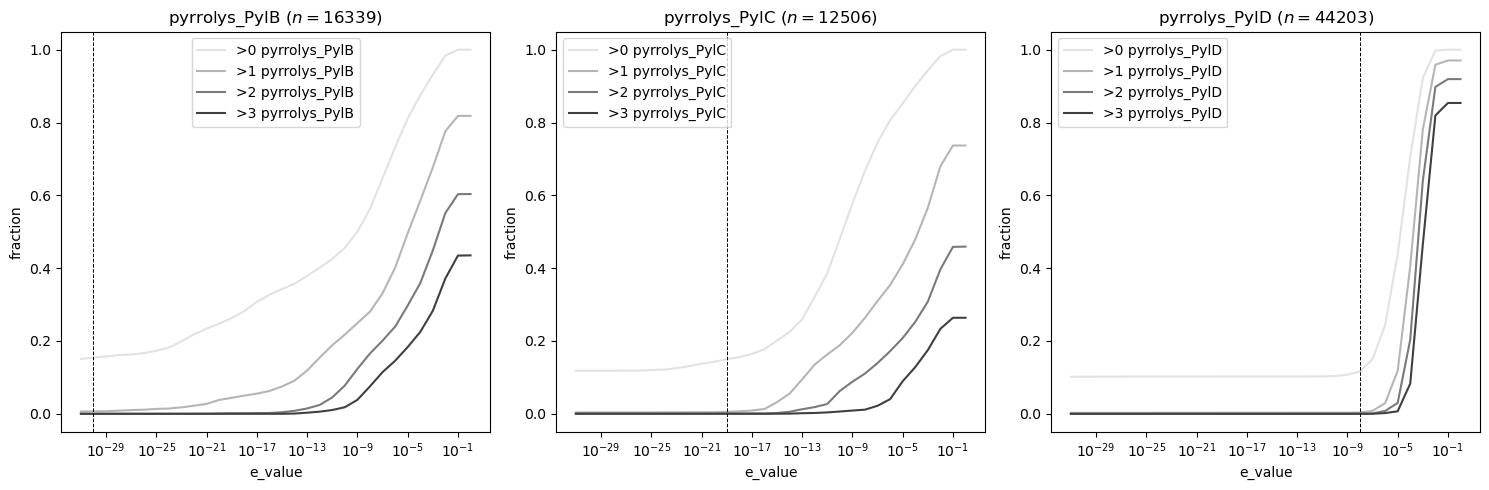

In [11]:
def figure(hmmer_df:pd.DataFrame, pyl_gene:str='pyrrolys_PylD', max_e_value:float=1e-8, ax:plt.Axes=None):
    # fig, ax = plt.subplots()

    # pyl_genes = ['pyrrolys_PylC', 'pyrrolys_PylD', 'pyrrolys_PylB']
    hmmer_df = hmmer_df[hmmer_df.query_name == pyl_gene].copy()

    e_values = [1 / (10**n) for n in range(32)] + [max_e_value]
    n_genomes = hmmer_df.genome_id.nunique() # How many genome IDs have any aRF-1 hit?

    figure_df = list()
    for min_pyl_hits in range(4):
        for e_value in e_values:
            pyl_hits_per_genome = hmmer_df[hmmer_df.e_value < e_value].genome_id.value_counts()
            n = (pyl_hits_per_genome > min_pyl_hits).sum() # Get the number of genomes with more than min_arf1_hits aRF-1 hits.
            figure_df.append({'e_value':e_value, 'fraction':n/n_genomes, 'min_pyl_hits':f'>{min_pyl_hits} {pyl_gene}'})
    figure_df = pd.DataFrame(figure_df)

    figure_df = pd.DataFrame(figure_df)
    sns.lineplot(figure_df, x='e_value', y='fraction', hue='min_pyl_hits', palette='Grays', ax=ax, legend=True)
    ax.set_xscale('log')
    ax.get_legend().set_title('')
    ax.set_title(f'{pyl_gene} ($n={len(hmmer_df)}$)')
    ax.axvline(max_e_value, ls='--', color='black', lw=0.7)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
figure(hmmer_df, ax=axes[0], pyl_gene='pyrrolys_PylB', max_e_value=1e-30)
figure(hmmer_df, ax=axes[1], pyl_gene='pyrrolys_PylC', max_e_value=1e-19)
figure(hmmer_df, ax=axes[2], pyl_gene='pyrrolys_PylD', max_e_value=1e-8)
fig.tight_layout()
plt.show()

MAX_E_VALUES = {'pyrrolys_PylB':1e-30, 'pyrrolys_PylC':1e-19, 'pyrrolys_PylD':1e-8}

# Based on examination of plots, it seems as though about 20 percent of genomes should have the entire operon. 
# Want to select thresholds where no (or very few) genomes have multiple copies. 


In [ ]:
def get_pyl_genome_ids(hmmer_df, max_e_values:float=MAX_E_VALUES, min_pyl_genes:list=['pyrrolys_PylC', 'pyrrolys_PylD', 'pyrrolys_PylB']):
    '''Return genome IDs which likely have Pyl machinery. This approach is similar to that in the Kivenson 2023 paper to identify
    genomes for organisms which could incorporate pyrrolysine. Default min_pyl_genes are all in the same operon, so should all be present
    if one is present.'''
    hmmer_df = hmmer_df[hmmer_df.query_name.str.contains('Pyl')].copy()
    hmmer_df['max_e_value'] = hmmer_df.query_name.map(max_e_values)
    hmmer_df = hmmer_df[hmmer_df.e_value < hmmer_df.max_e_value].copy() # Strong hits only. 

    # pyl_counts = hmmer_df.groupby('genome_id').apply(lambda df : df.query_name.nunique(), include_groups=False)
    # pyl_genome_ids = pyl_counts[pyl_counts > min_n_pyl_genes].index.values
    pyl_genome_ids = list()
    for genome_id, df in hmmer_df.groupby('genome_id'):
        if np.all(np.isin(min_pyl_genes, df.query_name.unique())):
            pyl_genome_ids.append(genome_id)
        
    return pyl_genome_ids

def get_no_pyl_genome_ids(hmmer_df, max_e_values:float=MAX_E_VALUES, genome_ids:list=hmmer_df.genome_id.unique(), max_n_pyl_genes:int=1):
    '''Return genome IDs which have no evidence of Pyl machinery'''
    hmmer_df = hmmer_df[hmmer_df.query_name.str.contains('Pyl')].copy()
    hmmer_df['max_e_value'] = hmmer_df.query_name.map(max_e_values)
    hmmer_df = hmmer_df[hmmer_df.e_value < hmmer_df.max_e_value].copy() # Strong hits only. 

    pyl_counts = hmmer_df.groupby('genome_id').apply(lambda df : df.query_name.nunique(), include_groups=False)
    pyl_genome_ids = pyl_counts[pyl_counts > max_n_pyl_genes].index.values # Look for organisms with max_n_pyl_genes or more Pyl genes. 
    no_pyl_genome_ids = genome_ids[~np.isin(genome_ids, pyl_genome_ids)]
    return no_pyl_genome_ids.tolist()

pyl_genome_ids = get_pyl_genome_ids(hmmer_df)
no_pyl_genome_ids = get_no_pyl_genome_ids(hmmer_df)

print('Num. genomes expressing Pyl machinery:', len(pyl_genome_ids))
print('Num. genomes with no evidence of Pyl machinery:', len(no_pyl_genome_ids))
print('Num. ambiguous genomes:', hmmer_df.genome_id.nunique() - (len(pyl_genome_ids) + len(no_pyl_genome_ids)))

Num. genomes expressing Pyl machinery: 513
Num. genomes with no evidence of Pyl machinery: 4592
Num. ambiguous genomes: 101


0.11171602787456446

In [ ]:
if not os.path.exists('../data/arf1.csv'):
    arf1_df = get_arf1_data(hmmer_df, genome_ids=pyl_genome_ids + no_pyl_genome_ids)
    arf1_df.to_csv('../data/arf1.csv')
else:
    arf1_df = pd.read_csv('../data/arf1.csv', index_col=0)

def parse_coords(coords:str):
    '''Parse a string containing the coordinates of each HMM hit, e.g. start..stop,start..stop.'''
    parsed_coords = list()
    for match_ in re.finditer(r'(\d+)\.\.(\d+)', coords):
        coord = (int(match_.group(1)), int(match_.group(2)))
        parsed_coords.append(coord)
    # print(parsed_coords)
    return parsed_coords

def get_min_coord(coords:str):
    return min([coord[0] for coord in parse_coords(coords)])

def get_max_coord(coords:str):
    return max([coord[1] for coord in parse_coords(coords)])

def get_alignment_length(coords:str):
    '''Get the length of the alignment, including gaps.'''
    return get_max_coord(coords) - get_min_coord(coords)

def get_biggest_gap(coords:str):
    '''Get the largest gap between regions of the target sequence which align to the HMM.'''
    coords = parse_coords(coords)   
    gap_sizes = [coords[i + 1][0] - coords[i][1] for i in range(len(coords) - 1)]
    return max(gap_sizes + [0]) # Accounts for there only being one hit. 

arf1_df['query_alignment_start'] = arf1_df.query_coords.apply(get_min_coord)
arf1_df['biggest_gap'] = arf1_df.envelope_coords.apply(get_biggest_gap)
arf1_df['alignment_length'] = arf1_df.envelope_coords.apply(get_alignment_length)

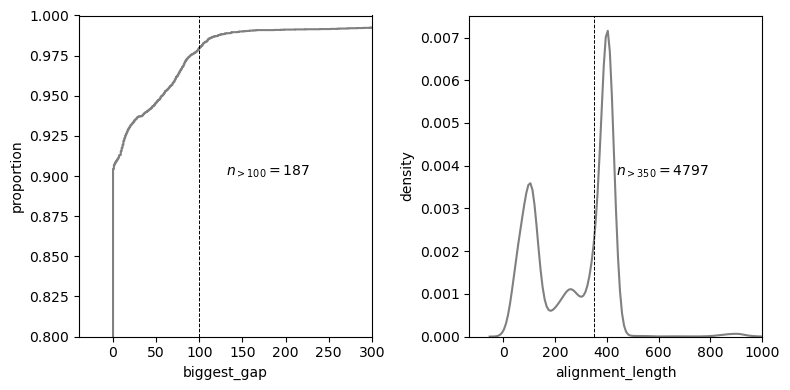

In [48]:
def figure(arf1_df:pd.DataFrame, max_gap:int=100, min_alignment_length:int=350):
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(8, 4))

    sns.ecdfplot(arf1_df, x='biggest_gap', ax=ax_a, color='gray')
    ax_a.axvline(max_gap, ls='--', color='black', lw=0.7)
    n = (arf1_df.biggest_gap > max_gap).sum()
    text = '$n_{>' + str(max_gap) + '}=$' + str(n)
    ax_a.text(0.5, 0.5, text, transform=ax_a.transAxes)
    ax_a.set_xlim(xmax=300)
    ax_a.set_ylim(ymin=0.8)
    ax_a.set_ylabel('proportion')

    sns.kdeplot(arf1_df, x='alignment_length', color='gray', ax=ax_b)
    ax_b.set_ylabel('density')
    ax_b.set_xlim(xmax=1000)
    ax_b.axvline(min_alignment_length, ls='--', color='black', lw=0.7)
    n = (arf1_df.alignment_length > min_alignment_length).sum()
    text = '$n_{>' + str(min_alignment_length) + '}=$' + str(n)
    ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes)

    plt.tight_layout()
    plt.show()

figure(arf1_df)


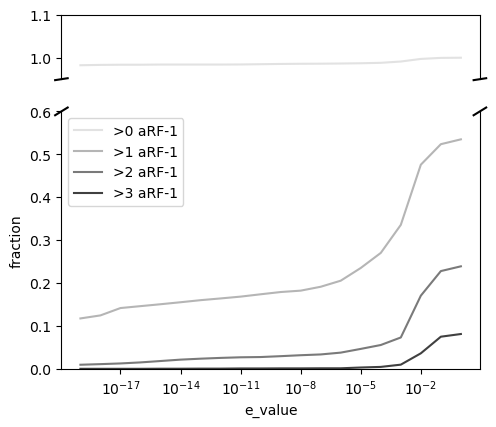

In [17]:
# We know that all organisms should have at least one type I release factor, so should select an E-value accordingly. 
# Plot the fraction of genomes with at least one annotated aRF-1 by selected threshold. 
def figure(arf1_df:pd.DataFrame):
    fig, (ax_top, ax_bottom) = get_split_figure((0, 0.6), (0.95, 1.1))

    e_values = [1 / (10**n) for n in range(20)]
    n_genomes = arf1_df.genome_id.nunique() # How many genome IDs have any aRF-1 hit?

    figure_df = list()
    for min_arf1_hits in range(4):
        for e_value in e_values:
            arf1_hits_per_genome = arf1_df[arf1_df.e_value < e_value].genome_id.value_counts()
            n = (arf1_hits_per_genome > min_arf1_hits).sum() # Get the number of genomes with more than min_arf1_hits aRF-1 hits.
            figure_df.append({'e_value':e_value, 'fraction':n/n_genomes, 'min_arf1_hits':f'>{min_arf1_hits} aRF-1'})
    figure_df = pd.DataFrame(figure_df)

    sns.lineplot(figure_df, x='e_value', y='fraction', hue='min_arf1_hits', palette='Grays', ax=ax_top, legend=False)
    sns.lineplot(figure_df, x='e_value', y='fraction', hue='min_arf1_hits', palette='Grays', ax=ax_bottom, legend=True)
    ax_bottom.get_legend().set_title('')
    ax_top.set_xscale('log')
    ax_top.set_ylabel('')
    ax_bottom.set_xscale('log')
    plt.show()

figure(arf1_df)
# We know that nothing should have more than 3 aRF-1s, and no more than ~10% (the fraction of Pyl-containing genomes)
# should have more than 1 aRF-1. Based on this 1-8 seems like a reasonable threshold. 

ARF1_MAX_E_VALUE = 1e-8

In [54]:
max_gap = 100
min_alignment_length = 350 

n = len(arf1_df)

# Steps to filter out any potential false positives. 
filters = dict()
filters['e_value'] = arf1_df.e_value < ARF1_MAX_E_VALUE
filters['partial'] = ~arf1_df.partial
filters['max_gap'] = arf1_df.biggest_gap < max_gap 
filters['min_alignment_length'] = arf1_df.alignment_length > min_alignment_length
filters['has_ggq_domain'] = arf1_df.seq.str.contains('GGQ')

for filter_name, mask in filters.items():
    print(f'Num. sequences removed by filter {filter_name}:', (~mask).sum(), f'({100 * (~mask).sum() / n:.2f}%)')

masks = list(filters.values())
mask = masks[0]
for mask_ in masks:
    mask = np.logical_and(mask, mask_)

arf1_df = arf1_df[mask].copy()
print('\nNum. aRF-1 sequences in final dataset:', len(arf1_df))

Num. sequences removed by filter e_value: 3387 (36.22%)
Num. sequences removed by filter partial: 557 (5.96%)
Num. sequences removed by filter max_gap: 192 (2.05%)
Num. sequences removed by filter min_alignment_length: 4553 (48.70%)
Num. sequences removed by filter has_ggq_domain: 4261 (45.57%)

Num. aRF-1 sequences in final dataset: 4498


In [55]:
arf1_df.sort_values('length')

,description,seq,length,partial,Unnamed: 0,query_name,e_value,query_coords,target_coords,envelope_coords,target_length,query_length,n_hits,genome_id,max_e_value,biggest_gap,alignment_length
NZ_CP029288.2_675,# 672356 # 673417 # -1 # ID=1_675;partial=00;s...,MKVLLKELKKWSAPATVLLSLYIPPGRPIADVLNNLRQEASISQNI...,354,False,3,aRF1_eRF1,5.200000e-132,"6..319,362..402","2..314,312..352","1..317,310..353",354,403,2,GCF_003201765.2,inf,0,352
NZ_WFIY01000004.1_1903,# 1675739 # 1676803 # -1 # ID=1_1903;partial=0...,MKVLLKELKKWSAPATVLLSLYIPPGRPIADVLNNLRQEASISQNI...,355,False,0,aRF1_eRF1,2.700000e-133,"6..317,362..402","2..312,312..352","1..315,309..353",355,403,2,GCF_009729545.1,inf,0,352
JAWASI010000006.1_56,# 51208 # 52272 # 1 # ID=6_56;partial=00;start...,MLKELKNWQAHATTLLSLYIPPGRPISDVVSLLRQELAITENIKLK...,355,False,1,aRF1_eRF1,7.500000e-120,"8..314,359..402","1..307,308..351","1..310,306..352",355,403,2,GCA_038892955.1,inf,0,351
AP024596.1_1813,# 1857513 # 1858577 # -1 # ID=1_1813;partial=0...,MKSLIKELKKWHSPATTLLSLYIPPGRPVADVINNLRQELSISQNI...,355,False,0,aRF1_eRF1,4.800000e-118,"5..315,358..402","1..310,309..353","1..314,307..354",355,403,2,GCA_019704295.1,inf,0,353
NZ_CP045482.1_1168,# 966739 # 967803 # 1 # ID=1_1168;partial=00;s...,MKVLLKELKKWSAPATVLLSLYIPPGRPIADVLNNLRQEASISQNI...,355,False,0,aRF1_eRF1,2.600000e-133,"6..317,362..402","2..312,312..352","1..315,309..353",355,403,2,GCF_009729015.1,inf,0,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JAGGZC010000035.1_16,# 13748 # 15253 # 1 # ID=16_16;partial=00;star...,MSLRDEDRIKLRAFIKKLEKVRGRHTELVSVYIPKGYSLNKILDHL...,502,False,1,aRF1_eRF1,1.300000e-121,"2..174,174..315,358..402","8..180,317..455,456..499","7..237,315..458,453..500",502,403,3,GCA_021162185.1,inf,78,493
NZ_WUYX01000023.1_17,# 17970 # 19490 # 1 # ID=39_17;partial=00;star...,MGPLNHAEHFESVLEYVDVGVSGGVFSRDITQALNTARRIDAGSAY...,507,False,0,aRF1_eRF1,5.100000e-73,"2..316,362..402","153..460,464..504","152..468,459..505",507,403,2,GCF_009834785.1,inf,0,353
JADFQH010000086.1_2,# 162 # 1688 # 1 # ID=52_2;partial=00;start_ty...,MSIFGRGNPYDSLSRSRKTNSSIRGLILLAVFLALAGGAHVSSMAP...,509,False,2,aRF1_eRF1,1.100000e-160,5..403,111..506,108..506,509,403,1,GCA_022561895.1,inf,0,398
JAGGZX010000069.1_16,# 15112 # 16644 # -1 # ID=48_16;partial=00;sta...,MGLNASISEADRLKLKSFINQLSRFRGRHTELVSVYIPQGYSLNKV...,511,False,1,aRF1_eRF1,7.300000e-116,"2..176,174..315,358..401","12..186,329..467,468..510","11..234,323..470,466..510",511,403,3,GCA_021161785.1,inf,89,499


In [ ]:

# # Because the NIKS domain is around residue 60-65, if the query alignment starts much past that residue, 
# # should probably not consider it an N-terminal hit. 
# def has_n_terminus(row, max_start:int=50):
#     '''Determine if any part of the sequence aligns to the N-terminus of the model.'''
#     query_coords = parse_coords(row.query_coords)
#     min_coord = min([coord[0] for coord in query_coords])
#     return min_coord < max_start

# def get_coordinate_span(coord:str):
#     # assert ',' not in coord, 'get_coordinate_span: More than one set of coordinates provided.'
#     if ',' in coord:
#         return np.nan
#     match_ = re.search(r'(\d+)\.\.(\d+)', coord)
#     return int(match_.group(2)) - int(match_.group(1))


In [ ]:
# def merge(coords:str, max_gap_size:int=0):
#     '''Some of the HMM hits overlap, which complicates analysis. Want to merge these hits to get runs of the 
#     target sequence which correspond to the HMM model. '''
#     coords = parse_coords(coords)
#     i = 0
#     while ((i + 1) < len(coords)):
#         gap_size = coords[i + 1][0] - coords[i][1]
#         if gap_size < max_gap_size:
#             merged_coord = _merge(coords.pop(i), coords.pop(i))
#             coords.insert(i, merged_coord)
#         else:
#             i += 1
#     coords = [(str(start), str(stop)) for start, stop in coords]
#     coords = ','.join(['..'.join(coord) for coord in coords])
#     return coords

# def _merge(coord_1, coord_2):
#     coords = list(coord_1) + list(coord_2)
#     return (min(coords), max(coords))

In [ ]:

arf1_df = arf1_df[arf1_df.seq.str.contains('GGQ')].copy() # Filter the aRF-1 hits for those with the catalytic site. 
arf1_df = arf1_df[~arf1_df.partial].copy() # Remove any partial sequences. 

arf1_df['has_niks_domain'] = arf1_df.seq.str.contains(niks_domain, regex=True)
arf1_df['has_ycf_domain'] = arf1_df.seq.str.contains(ycf_domain)
arf1_df['has_pyl'] = arf1_df.genome_id.isin(pyl_genome_ids)

# Seems as though the aRF-1 sequences with large gaps (exceeding 20 aa) are likely due to transposon insertions. 
arf1_df['envelope_coords_merged'] = arf1_df.envelope_coords.apply(merge)
arf1_df['alignment_length'] = arf1_df.envelope_coords_merged.apply(get_coordinate_span)
arf1_df['has_niks_domain'] = arf1_df.seq.str.contains(niks_domain, regex=True)
arf1_df = arf1_df[arf1_df.apply(has_n_terminus, axis=1)]
arf1_df = arf1_df[(arf1_df.alignment_length < 600) & (arf1_df.alignment_length > 300)].copy()
# arf1_df[~arf1_df.alignment_length.isnull()].sort_values('length')

# The YCF domain seems to occur before residue 150. 
# To make sure I grab the entire relevant region, perhaps take the stop coordinate of the first set of envelope coordinates, 
# and then check post-hoc to see how long the aligned region is.  

# arf1_df.drop(columns=['genome_id_x']).rename(columns={'genome_id_y':'genome_id'}).to_csv('../data/arf1.csv')

print('Num. genomes with an annotated aRF-1:', arf1_df.genome_id.nunique())
print('Num. Pyl genomes with an annotated aRF-1:', arf1_df[arf1_df.has_pyl].genome_id.nunique())
print('Num. non-Pyl genomes with an annotated aRF-1:', arf1_df[~arf1_df.has_pyl].genome_id.nunique())

FASTAFile().from_df(arf1_df).write('../data/arf1_cleaned.fa')


AttributeError: 'DataFrame' object has no attribute 'has_pyl'

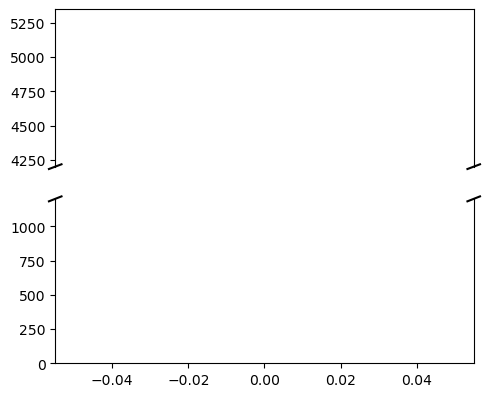

In [102]:
fig, (ax_top, ax_bottom) = get_split_figure((0, 1200), (4200, 5350))

# figure_df = pd.DataFrame(index=pd.Series(np.arange(1, 4), name='num_arf1'))
figure_df = list()
categories = ['pyl', 'pyl_niks', 'no_pyl', 'no_pyl_niks']
masks = [(arf1_df.has_pyl), (arf1_df.has_pyl & arf1_df.has_niks_domain), (~arf1_df.has_pyl), (~arf1_df.has_pyl & arf1_df.has_niks_domain)]
palette = {'pyl':'darkseagreen', 'pyl_niks':'seagreen', 'no_pyl':'indianred', 'no_pyl_niks':'firebrick'}

for category, mask in zip(categories, masks):
    num_arf1_counts = arf1_df[mask].groupby('genome_id').size().value_counts()
    figure_df += [{'num_arf1':n, 'count':num_arf1_counts.loc[n], 'category':category} for n in num_arf1_counts.index]
figure_df = pd.DataFrame(figure_df)
figure_df = figure_df[figure_df.num_arf1 < 4].copy()

# How many cases of Pyl-containing organisms with two ARF-1s and only one with a NIKS domain?
num_arf1_counts = arf1_df[arf1_df.has_pyl].groupby('genome_id').size()
genome_ids_multiple_arf1s = num_arf1_counts[num_arf1_counts > 1].index.values.tolist()

num_arf1_counts = arf1_df[arf1_df.has_niks_domain & arf1_df.genome_id.isin(genome_ids_multiple_arf1s)].groupby('genome_id').size()
genome_ids_multiple_arf1s_and_one_arf1_with_niks = num_arf1_counts[num_arf1_counts == 1].index.values.tolist()
genome_ids_multiple_arf1s_with_niks = num_arf1_counts[num_arf1_counts > 1].index.values.tolist()

print(len(genome_ids_multiple_arf1s))
print(len(genome_ids_multiple_arf1s_and_one_arf1_with_niks))
print(len(genome_ids_multiple_arf1s_with_niks))

sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_top, palette=palette) #, binsize=0.2)
sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_bottom, legend=False, palette=palette) #, binsize=0.2)
ax_top.set_ylabel('')
ax_top.get_legend().set_title('')
ax_bottom.set_xlabel('num. aRF-1')
plt.show()

# NIKS is asparagine, isoleucine, lysine, and serine.

sample_genome_ids = genome_ids_multiple_arf1s + no_pyl_genome_ids.tolist() + np.random.choice(pyl_genome_ids, 100, replace=False).tolist()

FASTAFile().from_df(arf1_df[arf1_df.genome_id.isin(sample_genome_ids)]).write('../data/arf1_cleaned_sample.fa') 


In [11]:
df = arf1_df[~arf1_df.has_niks_domain].copy()
arf1_df.has_ycf_domain.sum()
arf1_df.has_niks_domain.sum()

np.int64(6077)

In [12]:
recoded_genome_ids = table_5_metadata_df[table_5_metadata_df['Category 1'] > 50].index.unique()
arf1_df[arf1_df.genome_id.isin(recoded_genome_ids)]

,description,seq,length,partial,query_name,e_value,query_coords,target_coords,envelope_coords,target_length,query_length,n_hits,genome_id,has_niks_domain,has_ycf_domain,has_pyl,envelope_coords_merged,alignment_length
CP000300.1_1856,# 1826628 # 1827872 # 1 # ID=1_1856;partial=00...,MADQSSHQKYEFKKKLESLRGKKGRGTELISLYIPPDKQISDVVSQ...,415,False,aRF1_eRF1,4.200000e-185,1..403,8..412,8..412,415,403,1,GCA_000013725.1,True,True,True,8..412,404.0
CP001994.1_5,# 4690 # 5937 # 1 # ID=1_5;partial=00;start_ty...,MAEQSAHEKYEFKKKLESLRNKKGRGTELISLYIPPDKQLSDVTSQ...,416,False,aRF1_eRF1,6.100000e-181,1..403,8..413,8..413,416,403,1,GCA_000025865.1,True,True,True,8..413,405.0
CP002069.1_7,# 7352 # 8593 # 1 # ID=1_7;partial=00;start_ty...,MVEQSAHDKYEFKKKLEELRNKKGRGTELISLYLPPDKPISEVTSQ...,414,False,aRF1_eRF1,8.300000e-182,2..403,9..411,8..411,414,403,1,GCA_000196655.1,True,True,True,8..411,403.0
CP004049.1_1345,# 1384556 # 1385791 # -1 # ID=1_1345;partial=0...,MANDNSVSRARYDFKKAMEEIKNYRGKGTELISVYIPYGKLISDVM...,412,False,aRF1_eRF1,2.100000e-157,2..403,11..410,10..410,412,403,1,GCA_000300255.2,True,True,True,10..410,400.0
CP009518.1_5,# 5253 # 6497 # 1 # ID=1_5;partial=00;start_ty...,MADQSSHQKYEFKKKLESLRDKRGRGTELISLYIPPDKQLSDVVAQ...,415,False,aRF1_eRF1,2.700000e-182,1..403,8..412,8..412,415,403,1,GCA_000970325.1,True,True,True,8..412,404.0
MTMG01000008.1_119,# 108485 # 109717 # -1 # ID=4_119;partial=00;s...,MEIKKYEFKRQLEELQSKSGRGTELVSLYIPPGKPIHEVVADLKQE...,411,False,aRF1_eRF1,1.500000e-178,1..402,4..408,4..409,411,403,1,GCA_002010075.1,True,True,True,4..409,405.0
SMMS01000001.1_1248,# 1186414 # 1187661 # -1 # ID=1_1248;partial=0...,MAEQSAHEKYEFKKKLESLRNKKGRGTELISLYIPPDKQLSDVTSQ...,416,False,aRF1_eRF1,2.400000e-181,1..403,8..413,8..413,416,403,1,GCA_004340645.1,True,True,True,8..413,405.0
WRCE01000007.1_44,# 50302 # 51549 # 1 # ID=7_44;partial=00;start...,MAETSAHDRYEFKKKLEILRDKKGRSTELVALYIPPDKQISDVTAD...,416,False,aRF1_eRF1,1.900000e-174,2..403,9..413,8..413,416,403,1,GCA_009784005.1,True,True,True,8..413,405.0
JAGGLK010000002.1_100,# 102735 # 103979 # 1 # ID=2_100;partial=00;st...,MSEQSAHDKYEFKKKLESLRDKKGRGTELISLYIPPDKQISDVTSQ...,415,False,aRF1_eRF1,7.200000e-179,2..403,9..412,8..412,415,403,1,GCA_017874375.1,True,True,True,8..412,404.0
CP073710.1_1945,# 2068589 # 2069833 # 1 # ID=1_1945;partial=00...,MVDQSSHQKYEFKKKLESLRGKRGRGTELISLYIPPDKQLSDVVAQ...,415,False,aRF1_eRF1,9.000000e-182,1..403,8..412,8..412,415,403,1,GCA_021184045.1,True,True,True,8..412,404.0


In [13]:
arf1_df = get_arf1_data(hmmer_df, genome_ids=no_pyl_genome_ids)
arf1_df['length'] = arf1_df.seq.apply(len)
arf1_df['partial'] = ~arf1_df.description.str.contains('partial=00')

arf1_df = arf1_df[(arf1_df.length < 600) & (arf1_df.length > 300)].copy()
arf1_df = arf1_df[~arf1_df.partial].copy()
arf1_df = arf1_df[arf1_df.seq.str.contains('GGQ')].copy() # Make sure the release factors have the catalytic domain.
arf1_df = arf1_df[arf1_df.seq.str.contains('NIK[ST]', regex=True)].copy() # Make sure the release factors have the NIKS domain.

def get_niks_region(seq:str, window_size:int=50):
    pattern = r'NIK[ST]'
    match_ = re.search(pattern, seq)

    start = max(0, match_.start() - window_size)
    stop = max(0, match_.end() + window_size)
    return seq[start:stop]

arf1_df['seq'] = arf1_df.seq.apply(get_niks_region)

FASTAFile.from_df(arf1_df).write('../data/arf1_no_pyl.fa')
# ! mmseqs easy-cluster '../data/arf1_no_pyl.fa' '../data/arf1_no_pyl' '../data/tmp' --min-seq-id 0.90
# arf1_cluster_df = pd.read_csv('../data/arf1_no_pyl_cluster.tsv', sep='\t', names=['rep_id', 'id'])
# print('Num. clusters:', arf1_cluster_df.rep_id.nunique(), end='\n\n')

get_arf1_data: 100%|██████████| 1174/1174 [00:21<00:00, 53.85it/s]


In [14]:

dayhoff6 = {aa: grp for grp, aas in zip('abcdef', [['C'], ['A','G','P','S','T'], ['D','E','N','Q'], ['H','K','R'], ['I','L','M','V'], ['F','W','Y']]) for aa in aas}
reduced12 = {'A':'A','G':'A','S':'A','T':'A','P':'P','C':'C','D':'D','E':'D','N':'D','Q':'D','H':'H','K':'H','R':'H','I':'I','L':'I','M':'I','V':'I','F':'F','Y':'F','W':'F'}

def load_alignment(path:str=f'../data/arf1_no_pyl.afa', alphabet=dayhoff6):
    df = FASTAFile().from_fasta(path).to_df()
    index = df.index.values
    alignment = [list(seq) for seq in df.seq]

    if alphabet is not None:
        alignment = [[alphabet.get(aa, '-') for aa in row] for row in alignment]

    return index, np.array(alignment)

index, alignment = load_alignment(alphabet=reduced12)

Num. completely conserved residues: 7


Text(0.5, 1.0, 'aRF-1')

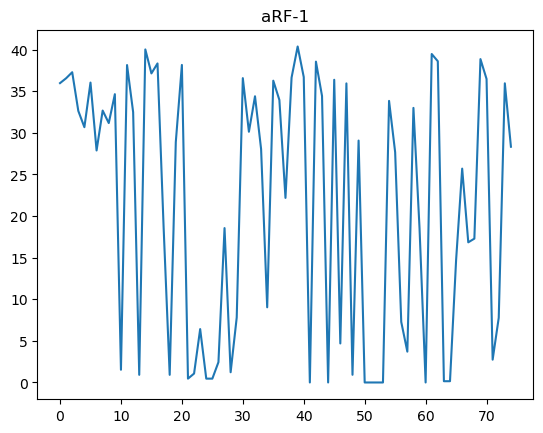

In [15]:

fig, ax = plt.subplots()

alignment = alignment[:, :75] # There's a gap in the alignment after 75. 

# domains = ['NIK[ST]', 'Y.C...F', 'GGQ']
domains = ['NIK[ST]']

conserved = [np.all(column == column[0]) for column in alignment.T]
print('Num. completely conserved residues:', sum(conserved))

probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
scores = [-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities]

sns.lineplot(x=np.arange(len(scores)), y=scores)
# for i in np.where(scores > 0.2)[0]:
#     ax.axvline(i, lw=0.7)
#     ax.text(i, ax.get_ylim()[-1], str(i), va='bottom', ha='center', rotation=90, color='tab:blue', fontsize='x-small')

ax.set_title('aRF-1')

In [16]:
# Key questions: 

# Are there any residues in the catalytically-active aRF-1 proteins in Pyl-utilizing archaea which are not present
# in any of the non-Pyl-utilizing archaea? Specifically looking around the NIKS binding site, and perhaps 
# with a specific focus on the organisms which seem to be largely re-coded (lots of category 1 genes).



In [17]:
''.join((alignment[np.where(groups == False)[0]][:, 36]))

# The N domain is responsible for stop codon recognition. Motifs include TASNIKS and YxCxxxF

NameError: name 'groups' is not defined

In [ ]:
''.join((alignment[np.where(groups == True)[0]][:, 36]))

'TTDTTTTTDTTTTTTTTTNTTT'

In [ ]:
FASTAFile('../data/ncbi/genomes/GCA_002505325.1.fn').to_df()
# ~/muscle5.1.linux_intel64 -align arf1.fa -output arf1.afa ous 

,description,seq
id,,
DAUV01000075.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GATCAACGTGTTTACGTCGAGGGTCAAGAGGCTCTGGCAGTTTCTG...
DAUV01000089.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GGAACGGAGGCTCTCAGCGTGGCGGATCGGCAGGATATAGTGAGCT...
DAUV01000031.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,CGAGCTCTCCAAGGCGGTCGCAGATATCATCGCCAGTGAGGTCAAC...
DAUV01000057.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,TCCGCGGCGTCCTCGGCCTCCTTACGGCGTCGCAGAATCTCAGGAC...
DAUV01000047.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,CCAAAAGAACAGCAGCGGGCGTGGCGCGTTGCGCGACCTCAGGGTG...
...,...,...
DAUV01000014.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,ACTTCGCATATGCTCAAAATGCAAAGGAGAATCATACAGAAGCCGG...
DAUV01000039.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GAACCTGTCATCGGCCTGTGGTCCCGGGTCGACGGACATTCTCTTG...
DAUV01000081.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GCTGTGAAATACGCAGACCTTTCTACAGAGAGGACGAAGGACTACG...
